In [1]:
print_imports()

Loaded modules:
Numpy                np              1.14.0
Pandas               pd              0.22.0
Keras                NOT LOADED      N/A

Matplotlib           mpl             2.1.2
matplotlib.pyplot    plt             N/A
matplotlib.image     mpimg           N/A
Seaborn              sns             0.8.1
PIL                  PIL             5.0.0

ExergyUtilities      exergy          2.0.

pyspark              NOT LOADED      N/A


In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import keras as ks

/home/batman/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
ks.backend.backend()

'tensorflow'

In [5]:
import tensorflow as tf
print(tf.__version__)
#tf.client.device_lib.list_local_devices()
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess)

1.0.1


In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 626139984526516980
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 209649664
locality {
  bus_id: 1
}
incarnation: 12201055985032051867
physical_device_desc: "device: 0, name: Quadro K2100M, pci bus id: 0000:01:00.0"
]


In [7]:
import os
import json
import copy
import time
from pprint import pprint

import shutil

<h4>Paths</h4>

In [8]:
root_path = "/media/batman/Windows/Dropbox/DATA/cats_dogs_small"

def my_splitpath(path, maxdepth=20):
     ( head, tail ) = os.path.split(path)
     return my_splitpath(head, maxdepth - 1) + [ tail ] \
         if maxdepth and head and head != path \
         else [ head or tail ]

data_dict = dict()

print("Files are organized as follows\n")

print("{:<10} {:<70} {}".format("files", "path", "key"))
for (path, dirs, files) in os.walk(root_path):
    
    files = [file for file in files]
    
    if len(files) > 0:
        total_split = my_splitpath(path)
        variablename = "_".join(total_split[-2:])
        print("{:<10} {:<70} {}".format(len(files), "/".join(total_split),variablename))
        data_dict[variablename] = dict()
        data_dict[variablename]['path'] = path
        data_dict[variablename]['file_count'] = len(files)

        
#pprint(data_dict)
path_test  = os.path.split(data_dict['test_cats']['path'])[0]
path_train   = os.path.split(data_dict['train_cats']['path'])[0]
path_val = os.path.split(data_dict['validation_cats']['path'])[0]
print("path_test", path_test)
print("path_val",path_val)
print("path_train",path_train)
#for k in data_dict:
#    print(k)


Files are organized as follows

files      path                                                                   key
1          //media/batman/Windows/Dropbox/DATA/cats_dogs_small                    DATA_cats_dogs_small
500        //media/batman/Windows/Dropbox/DATA/cats_dogs_small/test/cats          test_cats
500        //media/batman/Windows/Dropbox/DATA/cats_dogs_small/test/dogs          test_dogs
1000       //media/batman/Windows/Dropbox/DATA/cats_dogs_small/train/cats         train_cats
1000       //media/batman/Windows/Dropbox/DATA/cats_dogs_small/train/dogs         train_dogs
500        //media/batman/Windows/Dropbox/DATA/cats_dogs_small/validation/cats    validation_cats
500        //media/batman/Windows/Dropbox/DATA/cats_dogs_small/validation/dogs    validation_dogs
path_test /media/batman/Windows/Dropbox/DATA/cats_dogs_small/test
path_val /media/batman/Windows/Dropbox/DATA/cats_dogs_small/validation
path_train /media/batman/Windows/Dropbox/DATA/cats_dogs_small/train


<h4>Get a random selection</h4>

In [9]:
display_images = list()

# Get cats
this_path = data_dict["train_cats"]['path']
these_files = [os.path.join(this_path,f) for f in os.listdir(this_path) if os.path.isfile(os.path.join(this_path, f))]
np.random.shuffle(these_files)
display_images += these_files[0:4]

# Get dogs
this_path = data_dict["train_dogs"]['path']
these_files = [os.path.join(this_path,f) for f in os.listdir(this_path) if os.path.isfile(os.path.join(this_path, f))]
np.random.shuffle(these_files)
display_images += these_files[0:4]

# for i in display_images:
#     print(i)

#print(display_images)

<h4>Display some cats/docs</h4>

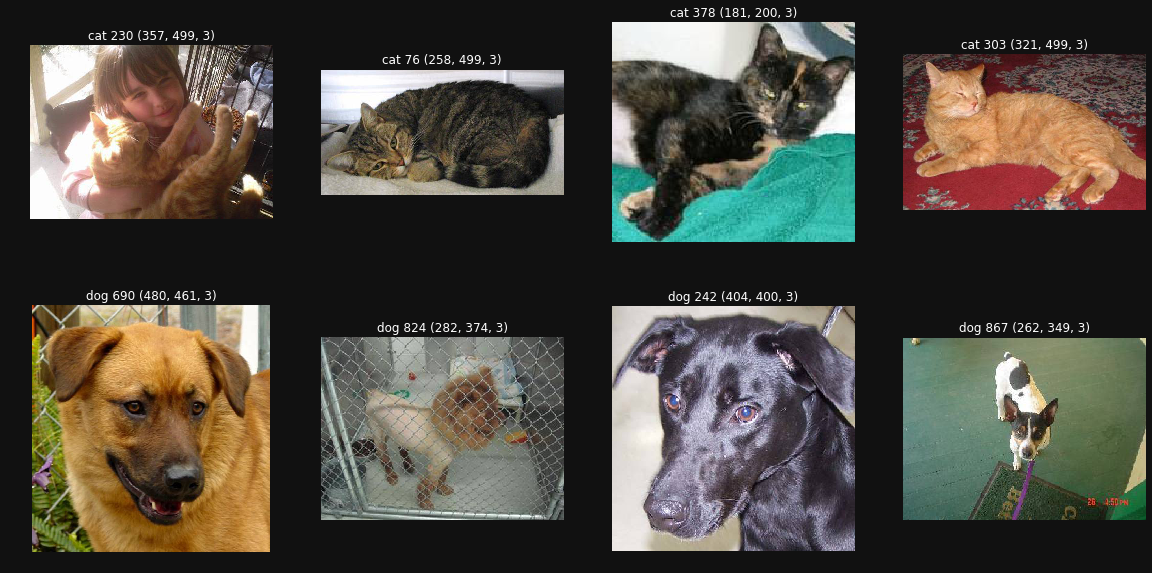

In [10]:
color = (17/255,17/255,17/255)
fig=plt.figure(figsize=(20, 10),facecolor=color)
columns = 4
rows = 2
for i in range(1, columns*rows +1):
    this_img_path = display_images[i - 1]
    fname = os.path.split(this_img_path)[-1]
    name, number = fname.split(".")[:2]
    img=mpimg.imread(this_img_path)
    this_ax = fig.add_subplot(rows, columns, i)

    this_ax.set_title("{} {} {}".format(name, number, img.shape,))
    plt.imshow(img)
    plt.axis("off")
plt.show()


<h4>Image flow generators</h4>

In [11]:
from keras.preprocessing import image as image_utils

# Training generator - Augmentation
train_datagen = image_utils.ImageDataGenerator(rescale=1/255,
                                              rotation_range = 40,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2,
                                              shear_range = 0.2,
                                              zoom_range= 0.2,
                                              horizontal_flip=True)

# Training generator - Simple
train_datagen = image_utils.ImageDataGenerator(rescale=1/255)

# Training images
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size = (150,150),
    batch_size = 20,
    class_mode = "binary"
);

# Validation images
validation_datagen = ks.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
    path_val,
    target_size = (150,150),
    batch_size = 20,
    class_mode = "binary"
);

print("Training: {} files over {} classes, resized to {}".format(
    len(train_generator.filenames),
    train_generator.num_classes,
    train_generator.target_size,
    ))

print("Validation: {} files over {} classes, resized to {}".format(
    len(validation_generator.filenames),
    validation_generator.num_classes,
    validation_generator.target_size,
    ))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Training: 2000 files over 2 classes, resized to (150, 150)
Validation: 1000 files over 2 classes, resized to (150, 150)


<h4>Define the network</h4>

In [12]:
model = ks.models.Sequential()

model.add(ks.layers.Conv2D(32, (3,3), activation = "relu", input_shape=(150,150,3)))
model.add(ks.layers.MaxPooling2D(2,2))

model.add(ks.layers.Conv2D(64, (3,3), activation = "relu"))
model.add(ks.layers.MaxPooling2D(2,2))

model.add(ks.layers.Conv2D(128, (3,3), activation = "relu"))
model.add(ks.layers.MaxPooling2D(2,2))

model.add(ks.layers.Conv2D(128, (3,3), activation = "relu"))
model.add(ks.layers.MaxPooling2D(2,2))

model.add(ks.layers.Flatten()) # This is just a reshape!

model.add(ks.layers.Dropout(0.5))

model.add(ks.layers.Dense(512,activation="relu"))
model.add(ks.layers.Dense(1,activation="sigmoid"))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [14]:
#ks.utils.plot_model(model, to_file='model.png')

In [15]:
model.compile(   
    optimizer = ks.optimizers.RMSprop(lr=0.0001),
    loss= ks.losses.binary_crossentropy,
    metrics= ["accuracy"],
)

In [16]:
%%script false
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs=30,
    validation_data = validation_generator,
    validation_steps = 50,
    )

In [18]:
start_time = time.time()
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs=30,
    validation_data = validation_generator,
    validation_steps = 50,
    )

print("Elapsed:", time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/30
100/100 [==============================] - 36s 356ms/step - loss: 0.5944 - acc: 0.6790 - val_loss: 0.6160 - val_acc: 0.6630
Epoch 2/30
100/100 [==============================] - 35s 350ms/step - loss: 0.5667 - acc: 0.6955 - val_loss: 0.6501 - val_acc: 0.6350
Epoch 3/30
100/100 [==============================] - 40s 398ms/step - loss: 0.5554 - acc: 0.7160 - val_loss: 0.6297 - val_acc: 0.6510
Epoch 4/30
100/100 [==============================] - 37s 367ms/step - loss: 0.5277 - acc: 0.7365 - val_loss: 0.6154 - val_acc: 0.6640
Epoch 5/30
100/100 [==============================] - 37s 370ms/step - loss: 0.5118 - acc: 0.7410 - val_loss: 0.6057 - val_acc: 0.6710
Epoch 6/30
100/100 [==============================] - 36s 364ms/step - loss: 0.4988 - acc: 0.7560 - val_loss: 0.5873 - val_acc: 0.6830
Epoch 7/30
100/100 [==============================] - 36s 357ms/step - loss: 0.4706 - acc: 0.7680 - val_loss: 0.6140 - val_acc: 0.6860
Epoch 8/30
100/100 [==============================] - 3

# Save the model, history, weights

In [19]:
# Save model to h5
path_h5_weights = r"saved_model_weights.hdf5"
model.save_weights(path_h5_weights)
print("Saved model weights to disk")

Saved model weights to disk


In [20]:
# Save model architecture to json
json_path = r"saved_model_architecture.json"

# serialize model to JSON
model_json = model.to_json()

# Write
with open(json_path, "w") as json_file:
    json_file.write(model_json)

History object

In [79]:

items = [i for i in dir(history)]

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
ch = chunks(items,3)

for triple in ch:
    #a,b,c = triple
    blank_trip = ["", "", ""]
    if len(triple)<3:
        triple.append("")
    print("{:>30} {:>30} {:>30}".format(*triple))
    #print(triple)

                     __class__                    __delattr__                       __dict__
                       __dir__                        __doc__                         __eq__
                    __format__                         __ge__               __getattribute__
                        __gt__                       __hash__                       __init__
             __init_subclass__                         __le__                         __lt__
                    __module__                         __ne__                        __new__
                    __reduce__                  __reduce_ex__                       __repr__
                   __setattr__                     __sizeof__                        __str__
              __subclasshook__                    __weakref__                          epoch
                       history                          model                 on_batch_begin
                  on_batch_end                 on_epoch_begin         

In [80]:
%%script  false
history_dict = copy.deepcopy(history.__dict__) # This stores validation_data, model, params, epoch, history
# THEREFORE history.history = history_dict['history'] -> redundant! 

In [81]:
history_dict = copy.copy(history.__dict__)
history_dict is history.__dict__
#pprint(history_dict)

False

In [84]:
for k in history_dict:
    print(k, type(history_dict[k]))
    
del history_dict['model']

path_history = r"saved_model_history.json"
#print(type(history_dict))

with open(path_history, 'w') as fp:
    json_string = json.dump(history_dict,fp)

print("Saved history.__dict__, but without the [model]=ks.model.Sequential ")

#history.history

validation_data <class 'NoneType'>
params <class 'dict'>
epoch <class 'list'>
history <class 'dict'>


KeyError: 'model'

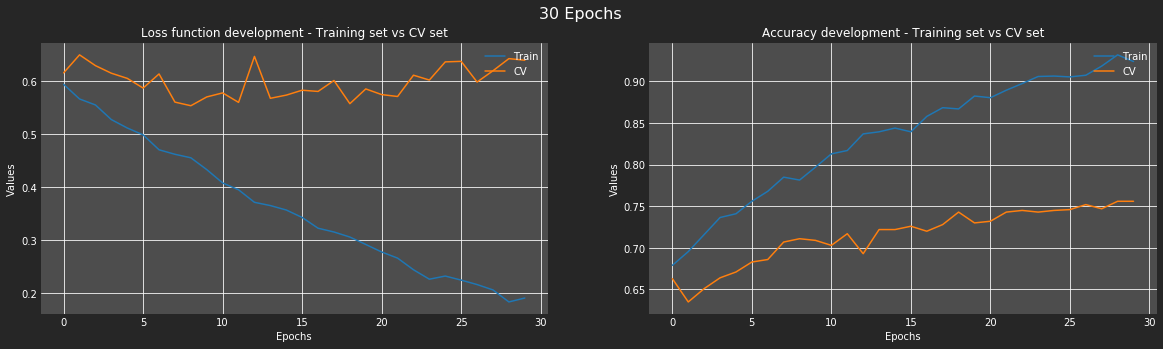

In [85]:
model_title = "30 Epochs"
def plot_hist(history_dict):
    #fig = plt.figure(figsize=(5,4))
    #fig=plt.figure(figsize=(20, 10),facecolor='white')

    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5),sharey=False,facecolor='white')
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5),sharey=False,facecolor='0.15')
    
    ax1.plot(history_dict['epoch'],  history_dict['history']['loss'],label="Train")
    ax1.plot(history_dict['epoch'],  history_dict['history']['val_loss'],label="CV")
    ax1.set_title("Loss function development - Training set vs CV set")
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Values')
    
    ax2.plot(history_dict['epoch'],  history_dict['history']['acc'],label="Train")
    ax2.plot(history_dict['epoch'],  history_dict['history']['val_acc'],label="CV")
    ax2.set_title("Accuracy development - Training set vs CV set")
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Values')
    
    plt.suptitle(model_title, fontsize=16)
    
    plt.show()

plot_hist(history_dict)

OTHER

In [ ]:
# 
# import matplotlib.pyplot as plt  
   
 
 # code for building your model  

 # train your model  
 history = model.fit(train_data, train_labels,  
                     nb_epoch=nb_epoch, batch_size=32,  
                     validation_data=(validation_data, validation_labels))  
   
 print(history.history.keys())  
   
 plt.figure(1)  
   
 # summarize history for accuracy  
   
 plt.subplot(211)  
 plt.plot(history.history['acc'])  
 plt.plot(history.history['val_acc'])  
 plt.title('model accuracy')  
 plt.ylabel('accuracy')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
 plt.subplot(212)  
 plt.plot(history.history['loss'])  
 plt.plot(history.history['val_loss'])  
 plt.title('model loss')  
 plt.ylabel('loss')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  
 plt.show()  